# Generalizability analysis

Here are the methods for different dataset partitioning strategies, the measure of similarity between two datasets using Tanimoto coefficient, a demo for TMAP plotting, and some charts for independent test sets.

The dataset was divided using three methods: Random, Stratified, and Scaffold.

In [50]:
import random
from collections import defaultdict
from typing import List, Set, Union, Dict
import numpy as np
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import train_test_split
from tqdm import tqdm


def generate_scaffold(smiles, include_chirality=False):
    """
    Obtain assert from smiles
    :param smiles:
    :param include_chirality:
    :return: smiles of scaffold
    """
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(
        smiles=smiles, includeChirality=include_chirality)
    return scaffold


def split_train_val_test_idx(idx, frac_train=0.8, frac_valid=0.2, sort=False, seed=42):
    random.seed(seed)

    np.testing.assert_almost_equal(frac_train + frac_valid, 1.0)
    total = len(idx)

    train_idx, valid_idx = train_test_split(idx, test_size=frac_valid, shuffle=True, random_state=seed)

    assert len(set(train_idx).intersection(set(valid_idx))) == 0
    assert len(train_idx) + len(valid_idx) == total

    if sort:
        train_idx = sorted(train_idx)
        valid_idx = sorted(valid_idx)

    return train_idx, valid_idx


def split_train_val_test_idx_stratified(idx, y, frac_train=0.8, frac_valid=0.2, sort=False, seed=42):
    random.seed(seed)

    np.testing.assert_almost_equal(frac_train + frac_valid , 1.0)
    total = len(idx)

    train_idx, valid_idx, y_train, _ = train_test_split(idx, y, test_size=frac_valid, shuffle=True, stratify=y,
                                                        random_state=seed)

    assert len(set(train_idx).intersection(set(valid_idx))) == 0
    assert len(train_idx) + len(valid_idx) == total

    if sort:
        train_idx = sorted(train_idx)
        valid_idx = sorted(valid_idx)

    return train_idx, valid_idx


def scaffold_split_train_val_test(index, smiles_list, frac_train=0.8, frac_valid=0.1, frac_test=0.1, sort=False):
    np.testing.assert_almost_equal(frac_train + frac_valid, 1.0)

    index = np.array(index)

    # create dict of the form {scaffold_i: [idx1, idx....]}
    all_scaffolds = {}
    for i, smiles in enumerate(smiles_list):
        scaffold = generate_scaffold(smiles, include_chirality=True) # 提取骨架
        if scaffold not in all_scaffolds:
            all_scaffolds[scaffold] = [i]
        else:
            all_scaffolds[scaffold].append(i)

    # sort from largest to smallest sets
    all_scaffolds = {key: sorted(value) for key, value in all_scaffolds.items()}
    all_scaffold_sets = [
        scaffold_set for (scaffold, scaffold_set) in sorted(
            all_scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]

    # get train, valid test indices
    train_cutoff = frac_train * len(smiles_list)
    valid_cutoff = (frac_train + frac_valid) * len(smiles_list)
    train_idx, valid_idx = [], []
    for scaffold_set in all_scaffold_sets:
        if len(train_idx) + len(scaffold_set) > train_cutoff:
            valid_idx.extend(scaffold_set)
        else:
            train_idx.extend(scaffold_set)

    assert len(set(train_idx).intersection(set(valid_idx))) == 0

    train_index, val_index = index[train_idx], index[valid_idx]

    if sort:
        train_index = sorted(train_index)
        val_index = sorted(val_index)

    return train_index, val_index


def random_scaffold_split_train_val_test(index, smiles_list, frac_train=0.9, frac_valid=0.1,
                                         sort=False, seed=42):
    np.testing.assert_almost_equal(frac_train + frac_valid , 1.0)

    index = np.array(index)

    rng = np.random.RandomState(seed)

    scaffolds = defaultdict(list)
    for ind, smiles in enumerate(smiles_list):
        scaffold = generate_scaffold(smiles, include_chirality=True)
        scaffolds[scaffold].append(ind)

    scaffold_sets = rng.permutation(np.array(list(scaffolds.values()), dtype=object))

    n_total_valid = int(np.floor(frac_valid * len(index)))

    train_idx = []
    valid_idx = []

    for scaffold_set in scaffold_sets:
        if len(valid_idx) + len(scaffold_set) <= n_total_valid:
            valid_idx.extend(scaffold_set)
        else:
            train_idx.extend(scaffold_set)

    assert len(set(train_idx).intersection(set(valid_idx))) == 0

    train_index, val_index = index[train_idx], index[valid_idx]

    if sort:
        train_index = sorted(train_index)
        val_index = sorted(val_index)

    return train_index, val_index


def scaffold_to_smiles(mols: Union[List[str], List[Chem.Mol]],
                       use_indices: bool = False) -> Dict[str, Union[Set[str], Set[int]]]:
    """
    Computes scaffold for each smiles string and returns a mapping from scaffolds to sets of smiles.

    :param mols: A list of smiles strings or RDKit molecules.
    :param use_indices: Whether to map to the smiles' index in all_smiles rather than mapping
    to the smiles string itself. This is necessary if there are duplicate smiles.
    :return: A dictionary mapping each unique scaffold to all smiles (or smiles indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, mol in tqdm(enumerate(mols), total=len(mols)):
        if Chem.MolFromSmiles(mol) != None:
            scaffold = generate_scaffold(mol,True)
            if use_indices:
                scaffolds[scaffold].add(i)
            else:
                scaffolds[scaffold].add(mol)

    return scaffolds


def scaffold_split_balanced_train_val_test(index, smiles_list,
                                           frac_train=0.9, frac_valid=0.1,
                                           balanced: bool = False,
                                           seed: int = 0):
    """
    Split a dataset by scaffold so that no molecules sharing a scaffold are in the same split.

    :param data: A MoleculeDataset.
    :param sizes: A length-3 tuple with the proportions of data in the
    train, validation, and test sets.
    :param balanced: Try to balance sizes of scaffolds in each set, rather than just putting smallest in test set.
    :param seed: Seed for shuffling when doing balanced splitting.
    :param logger: A logger.
    :return: A tuple containing the train, validation, and test splits of the data.
    """
    np.testing.assert_almost_equal(frac_train + frac_valid, 1.0)

    index = np.array(index)

    # Split
    train_size, val_size = frac_train * len(smiles_list), frac_valid * len(smiles_list)
    train, val = [], []
    train_scaffold_count, val_scaffold_count = 0, 0

    # Map from scaffold to index in the smiles
    scaffold_to_indices = scaffold_to_smiles(smiles_list, use_indices=True)

    if balanced:  # Put stuff that's bigger than half the val/test size into train, rest just order randomly
        index_sets = list(scaffold_to_indices.values())
        big_index_sets = []
        small_index_sets = []
        for index_set in index_sets:
            if len(index_set) > val_size / 2:
                big_index_sets.append(index_set)
            else:
                small_index_sets.append(index_set)
        random.seed(seed)
        random.shuffle(big_index_sets)
        random.shuffle(small_index_sets)
        index_sets = big_index_sets + small_index_sets
    else:  # Sort from largest to smallest scaffold sets
        index_sets = sorted(list(scaffold_to_indices.values()), key=lambda index_set: len(index_set), reverse=True)

    for index_set in index_sets:
        if len(train) + len(index_set) <= train_size:
            train += index_set
            train_scaffold_count += 1
        elif len(val) + len(index_set) <= val_size:
            val += index_set
            val_scaffold_count += 1

    print(
        f'Total scaffolds = {len(scaffold_to_indices)} | train scaffolds = {train_scaffold_count} | val scaffolds = {val_scaffold_count}')

    train_idx = index[train]
    val_idx = index[val]

    return train_idx, val_idx


The measure of similarity between two datasets using Tanimoto coefficient.

In [51]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

def calculate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2) 
        return fp
    else:
        return None

def calculate_similarity(smiles1, smiles2):
    fp1 = calculate_fingerprint(smiles1)
    fp2 = calculate_fingerprint(smiles2)
    if fp1 is not None and fp2 is not None:
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2) 
        return similarity
    else:
        return None
    
calculate_similarity("CCCCCCCC","CCCNNNNCCCCOOOC")

0.1724137931034483

two datasets

In [52]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

def calculate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    return None

def calculate_tanimoto_similarity(fp1, fp2):
    if fp1 and fp2:
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    return 0

def max_similarity(smiles, listB):
    fp1 = calculate_fingerprint(smiles)
    max_sim = 0
    for smilesB in listB:
        fp2 = calculate_fingerprint(smilesB)
        sim = calculate_tanimoto_similarity(fp1, fp2)
        max_sim = max(max_sim, sim)
    return max_sim

def list_max_similarity(listA, listB):
    return [max_similarity(smilesA, listB) for smilesA in listA]

# 示例数据
listA = ['CCCC', 'CCCCC', 'CCO', 'CCN']
listB = ['CCCN', 'CCCC', 'CCCl']

# 计算
results = list_max_similarity(listA, listB)
print(results)

[1.0, 0.5, 0.375, 0.5555555555555556]


## Similarity analysis between independent test set and benchmark test set

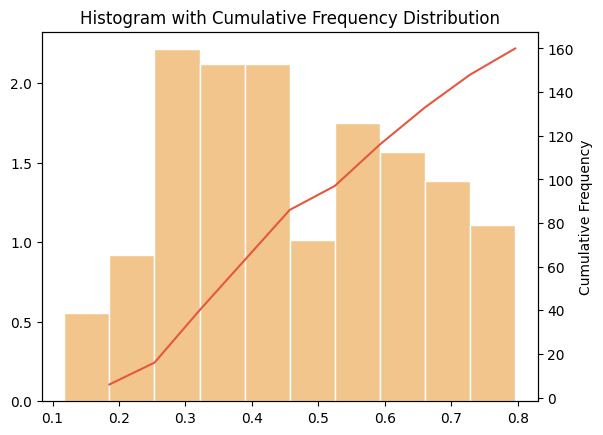

In [47]:
import json
import warnings
import pandas as pd
from rdkit import RDLogger
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL) 
warnings.filterwarnings('ignore')
with open('/dataset/independent.json', 'r') as f:
    data1 = json.load(f) 
inde = [pred1["smiles"] for pred1 in data1]
with open('/dataset/dataset_9641.json', 'r') as f:
    data2 = json.load(f)      
train = [pred2["smiles"] for pred2 in data2]
import matplotlib.pyplot as plt

data = list_max_similarity(inde, train)

plt.hist(data,bins=10,color='#f2c58c',edgecolor = "white",cumulative=False, density=True)
hist,bin_edges=np.histogram(data,bins=10)
cumulative_freg =np.cumsum(hist)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(bin_edges[1:], cumulative_freg, color='#e45840')
ax2.set_ylabel('Cumulative Frequency')
plt.title("Histogram with Cumulative Frequency Distribution")
plt.xlabel("Value")
plt.ylabel("Cumulative Frequency")
plt.show()


## results on independent dataset

In [2]:
import torch
import gvp.MSCSolmodel
import features.data
from datetime import datetime
import os, json
from tqdm import tqdm
import numpy as np
import torch_geometric
import json
from math import sqrt
from functools import partial
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import warnings
import pandas as pd
from rdkit import RDLogger
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL) 
warnings.filterwarnings('ignore')

node_dim = (100, 16)
edge_dim = (32, 1)

print = partial(print, flush=True)
device = torch.device("cuda:0")

model_id = int(datetime.timestamp(datetime.now()))

dataloader2 = lambda x: torch_geometric.loader.DataLoader(x, 
                        num_workers=1,drop_last=False,
                        batch_size =64)
import csv

def main():
    with open('/dataset/independent.json', 'r') as f:
        dataset = json.load(f)    

    pretrain = ["/trained_models/all_models/MSCSol_dataaug_benchmark_re_fold_0.pt",
                "/trained_models/all_models/MSCSol_dataaug_benchmark_re_fold_1.pt",
                "/trained_models/all_models/MSCSol_dataaug_benchmark_re_fold_2.pt",
                "/trained_models/all_models/MSCSol_dataaug_benchmark_re_fold_3.pt",
                "/trained_models/all_models/MSCSol_dataaug_benchmark_re_fold_4.pt",]
    re_MAE = []
    re_MSE = []
    re_RMSE = []
    re_R2 = []
    for i in pretrain:
            valset = dataset

            model = gvp.MSCSolmodel.Model((7, 2), node_dim, (32, 1), edge_dim).to(device)
            model.load_state_dict(torch.load(i))

            valset = features.data.GraphDataset(valset,img_transformer='val')

            val_loader = dataloader2(valset)
            
            model.eval()
            with torch.no_grad():

                y_data_valid = []
                y_pred_valid = []
                id_valid = []
                y_data_valid = np.array(y_data_valid)
                y_data_valid = np.array(y_data_valid)
                id_valid = np.array(id_valid)
                
                N = len(val_loader)
                for step, batch in tqdm(enumerate(val_loader), disable=True, total=N):

                    y_data = []
                    y_pred = []
                    y_data = np.array(y_data)
                    y_pred = np.array(y_pred)


                    batch = batch.to(device)
                    h_V = (batch.node_s, batch.node_v)
                    h_E = (batch.edge_s, batch.edge_v)
                    
                    predictions = model(h_V, batch.edge_index, h_E, seq=batch.seq,batch33 = batch.batch,feature_molecule=batch.feature_molecule,picdata = batch.picdata)
                    solu = batch.solu
                    predictions = torch.squeeze(predictions)
                    
                    solu_list = solu.cpu().detach().numpy()
                    predictions_list = predictions.cpu().detach().numpy()
                    y_data = np.append(y_data,solu_list)
                    y_pred = np.append(y_pred, predictions_list)

                    y_data_valid = np.append(y_data_valid, solu_list)
                    y_pred_valid = np.append(y_pred_valid, predictions_list)
                    id_valid = np.append(id_valid, batch.id.tolist())

            re_MAE.append(mean_absolute_error(y_data_valid, y_pred_valid))
            re_MSE.append(mean_squared_error(y_data_valid, y_pred_valid))
            re_RMSE.append(sqrt(mean_squared_error(y_data_valid, y_pred_valid)))
            re_R2.append(r2_score(y_data_valid, y_pred_valid))

    print("MAE: "+str(sum(re_MAE) / len(re_MAE)))
    print("MSE: "+str(sum(re_MSE) / len(re_MSE)))
    print("RMSE: "+str(sum(re_RMSE) / len(re_RMSE)))
    print("R2: "+str(sum(re_R2) / len(re_R2)))

    
if __name__== "__main__":
    main()


MAE: 0.8878666016658148
MSE: 1.0870260725812357
RMSE: 1.0422101062557299
R2: 0.7388887072967305


# TMAP
## Source
website: https://tmap.gdb.tools/

tmap is a very fast visualization library for large, high-dimensional data sets. Currently, tmap is available for Python.

## Installation
tmap is installed using the conda package manager. Don't have conda? Download miniconda.

conda install -c tmap tmap

We suggest using faerun to plot the data layed out by tmap. But you can of course also use matplotlib (which might be to slow for large data sets and doesn't provide interactive features). Following, an example plot produced with tmap and matplotlib.

<img src="./pic/TMAP_demo.png" width="800" height="300">


In [ ]:
import pickle
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import tmap as tm

from faerun import Faerun


def main():
    """ Main function """

    dims = 512
    lf = tm.LSHForest(dims, 128, store=True)

    # Due to the large data size (> 1GB) the following files are not provided directly
    smiles, target_class, activity, chembl_id = pickle.load(open("chembl.pickle", "rb"))

    labels = []
    for i, s in enumerate(smiles):
        labels.append(
            s
            + "__"
            + chembl_id[i]
            + "__"
            + f'<a target="_blank" href="https://www.ebi.ac.uk/chembl/compound_report_card/{chembl_id[i]}">{chembl_id[i]}</a>'
        )

    lf.restore("chembl.dat")

    target_class_map = dict(
        [(y, x + 1) for x, y in enumerate(sorted(set(target_class)))]
    )

    classes = [
        "enzyme",
        "kinase",
        "protease",
        "cytochrome p450",
        "ion channel",
        "transporter",
        "transcription factor",
        "membrane receptor",
        "epigenetic regulator",
    ]

    i = 0
    for key, value in target_class_map.items():
        if key not in classes:
            target_class_map[key] = 7
        else:
            target_class_map[key] = i
            i += 1
            if i == 7:
                i = 8

    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 70
    cfg.mmm_repeats = 2
    cfg.sl_repeats = 2

    start = timer()
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)
    end = timer()
    print(end - start)

    activity = np.array(activity)
    activity = np.maximum(0.0, activity)
    activity = np.minimum(100.0, activity)
    activity = 10.0 - activity

    legend_labels = [
        (0, "Cytochrome p450"),
        (1, "Other Enzyme"),
        (2, "Epigenetic Regulator"),
        (3, "Ion Channel"),
        (4, "Kinase"),
        (5, "Membrane Receptor"),
        (6, "Protease"),
        (8, "Transcription Factor"),
        (9, "Transporter"),
        (7, "Other"),
    ]

    vals = [int(target_class_map[x]) for x in target_class]

    faerun = Faerun(view="front", coords=False)
    faerun.add_scatter(
        "chembl",
        {"x": x, "y": y, "c": vals, "labels": labels},
        colormap="tab10",
        point_scale=1.0,
        max_point_size=10,
        has_legend=True,
        categorical=True,
        shader="sphere",
        legend_labels=legend_labels,
        title_index=1,
    )
    faerun.add_tree(
        "chembl_tree", {"from": s, "to": t}, point_helper="chembl", color="#222222"
    )

    faerun.plot("chembl", template="smiles")


if __name__ == "__main__":
    main()

demo URL: https://tmap.gdb.tools/src/chembl/chembl.html

and ours:

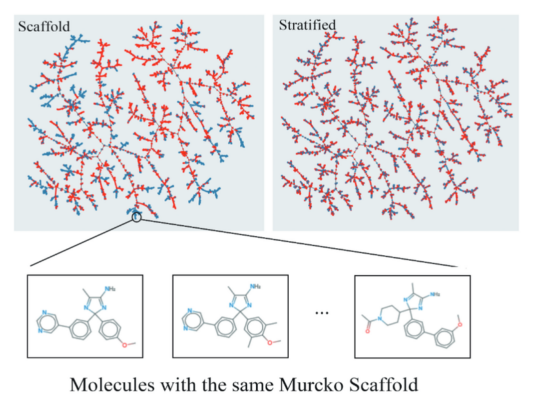

In [53]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('./pic/TMAP.png')

new_size = (800, 600)  
img_resized = img.resize(new_size, Image.ANTIALIAS) 

plt.figure(figsize=(7, 5)) 
plt.imshow(img_resized)
plt.axis('off')
plt.show()